This notebook will specifically use data from the Allen Insitute for Neural Dynamics and show how we can leverage CEBRA to analyse our in-house data. Here we will check if we can distinguish right vs left trials in the foraging task data.

In [1]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import utils


from matplotlib.collections import LineCollection
import pandas as pd

## A. Load the Data

Here we load data from the Fibre Photometry pipeline of 4 Neuromodulators (DA, 5HT, ACh, NE) recorded in the Nucleus Acumbens region. The main neural data will be in the form of dF_F traces of these 4 Neuromodulators (NMs). These will be stored in a 2D array, 'all_nms'.

In [2]:
pd.__version__

'2.0.0'

In [3]:
#pip install pandas==2.0.0

In [4]:
# load the dataframe that contains data from 1 session
df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))

In [5]:
df_trials_ses.columns

Index(['bit_code', 'ses_idx', 'rpe', 'left_action_value', 'right_action_value',
       'licks L', 'licks R', 'Lick L (raw)', 'Lick R (raw)', 'trial', 'reward',
       'choice', 'go_cue_absolute_time', 'go_cue', 'choice_time',
       'reward_time', 'onset', 'NM', 'NM_name', 'region', 'last_value_NM',
       'overlap_index', 'NM_no_overlap', 'bins_mids', 'bins_mids_no_overlap'],
      dtype='object')

In [6]:
l1 = df_trials_ses['licks L'].iloc[:1765].values
l2 = df_trials_ses['licks L'].iloc[3530:5295].values
np.sum(l1-l2)

0.0

In [7]:
df_trials_ses[['licks L', 'licks R']]

,licks L,licks R
0,26.0,0.0
1,10.0,0.0
2,2.0,0.0
3,2.0,0.0
4,1.0,0.0
...,...,...
1760,1.0,0.0
1761,3.0,0.0
1762,2.0,0.0
1763,1.0,0.0


In [8]:
df_trials_ses[['licks L', 'licks R']].describe()

,licks L,licks R
count,7060.000000,7060.000000
mean,1.309915,2.229462
std,2.377764,3.430823
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,2.000000
max,26.000000,21.000000


In [9]:
np.unique(df_trials_ses['Lick L (raw)'].iloc[7], return_counts=True)

(array([0., 1.]), array([117,   1]))

NB: There's 1765 trials in this data frame (the indices are repeated over each neuromodulator)
all information is in the first 1765 rows so we'll consider those

In [10]:
n_trials = 1765

In [11]:
# download the dictionary containing the traces
traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))

In [12]:
# load the trace times
trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)

In [13]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [14]:
# Combine the traces into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape


(218572, 4)

In [15]:
all_nms.shape

(218572, 4)

In [16]:
# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape

(218572, 4)

In [17]:
# convert it to a tensor (this is probably not necessary but we want it to be as close to the inputs in the previous notebook)
all_nms_tensor = torch.from_numpy(all_nms_new)
all_nms_tensor.shape

torch.Size([218572, 4])

## B. Format data and create the behavioural/auxiliary variables

Now let's format the data. We want to view the data in a 1 second window around the choice time at each trial in the session. The hope is that this will make it easy to identify the trials where it chose to lick left and those where it chose to lick right.

Each trial will be labelled as rewarded/unrewarded and this will be the behavioural variable we use for this analysis.

In [18]:
ins = np.argwhere(df_trials_ses['licks R'] > df_trials_ses['licks L'])

In [19]:
df_trials_ses['licks L'].to_numpy()

array([26., 10.,  2., ...,  2.,  1.,  1.])

In [20]:
444/(6616+444)

0.06288951841359773

In [21]:
6616+444

7060

6% of the trials had an equal number of left and right licks

In [22]:
indxs = np.argwhere(df_trials_ses['licks L'] == df_trials_ses['licks R'])

In [23]:
np.unique(df_trials_ses['licks L'].to_numpy()[indxs],return_counts=True)

(array([0., 1., 2.]), array([184, 240,  20]))

For the trials where the number of left and right trials are equal, the number of licks in either direction is either 0,1 or 2.

In [24]:
# Make a function to format the NM data into a 1s window around the choice

def format_data(neural_data, df, trace_times_, choice_times_ , window=None , window_size=10, n_trials=1765):

    # define the number of trials where the mouse made a choice
    n_choice_trials = np.unique(np.isnan(choice_times_),return_counts=True)[1][0]

    # list to hold all the 1s windows
    n_data_window = []

    # new trial label
    trial_labels = []

    # magnitude label (number of licks)
    n_licks = []

    # loop over all trials
    for i in range(0,n_trials):

        # skip trials where the animal didn't make a choice (null choice time)
        if np.isnan(choice_times_[i]):
            continue

        # find the index of the closest time to the choice time in the trace_times array 
        idx = np.abs(trace_times_ - choice_times_[i]).argmin()

        # take the previous 10 and/or the next 10 values of the NM data at these indices - 1s window
        if window =='before':
            n_data_window.append(neural_data[idx-10:idx])

        if window == 'after':
            n_data_window.append(neural_data[idx:idx+10])

        if window == None:
            n_data_window.append(neural_data[idx-10:idx+10])

        # label the timepoints as left or right choice
        if df['licks L'].iloc[i] >= df['licks R'].iloc[i]:
            # new trial label
            trial_labels.append(1)
            n_licks.append(df['licks L'].iloc[i])

        elif df['licks R'].iloc[i] > df['licks L'].iloc[i]:
            # new trial label
            choice_labels.append(0)
            n_licks.append(df['licks R'].iloc[i])


    # stack the nm data for each trial
    nms_HD = np.stack(n_data_window).reshape((n_choice_trials,-1))
    # format it into a tensor
    nms_HD = torch.from_numpy(nms_HD.astype(np.float64))
    print("neural tensor shape: ", nms_HD.shape)

    # convert trial labels into an array
    choice_labels = np.array(trial_labels)
    n_licks = np.array(n_licks)
    print("labels shape: ",trial_labels.shape)
    print("number of licks:", n_licks.shape)

    return nms_HD, trial_labels, n_licks

In [25]:
formatted_nms, trial_labels, n_licks = format_data(all_nms,df=df_trials_ses,trace_times_=trace_times, choice_times_=choice_times)

UnboundLocalError: local variable 'choice_labels' referenced before assignment

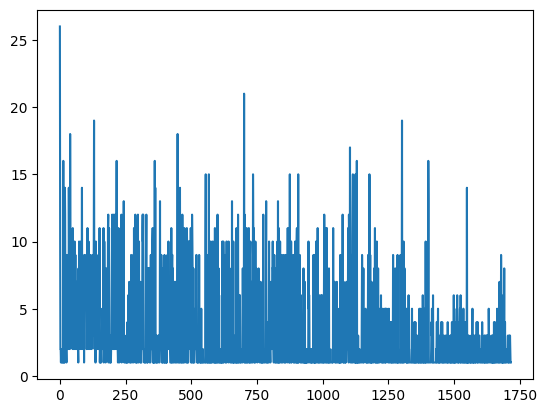

In [ ]:
plt.plot(n_licks)

In [ ]:
# let's make a behaviour label that gives information on both the direction and how many licks in that direction it took
# -- use the 3D array like they did in the hippocampus demo

# but first let's start with just whether it licked left or right

Out of the 1765 trials in the session, this particular mouse made a choice in 1717 of them. So we will only use those trials. Therefore we have a binary array of shape (1717,) as our behavioural label. The NM data is organized such that we have 20 timesteps for each of the 4 neuromodulators in this 1 second window.

## C. Build and train the CEBRA models

In [ ]:
# set the maximum number of iterations for training the model
max_iterations = 2000

In [ ]:
# build a CEBRA-Time and CEBRA-Behaviour model
cebra_time_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [ ]:
cebra_behaviour_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

Train the two models

In [ ]:
# train the time model (no labels here)
cebra_time_model.fit(formatted_nms)

pos:  0.9001 neg:  2.9590 total:  3.8591 temperature:  1.0000: 100%|██████████| 2000/2000 [00:49<00:00, 40.21it/s]


CEBRA(batch_size=512, conditional='time', distance='euclidean',
      max_iterations=2000, model_architecture='offset10-model-mse',
      output_dimension=3, temperature=1, time_offsets=10, verbose=True)

In [ ]:
# train the behaviour model (use the labels here)
cebra_behaviour_model.fit(formatted_nms, trial_labels)

pos:  0.3774 neg:  5.7311 total:  6.1086 temperature:  1.0000: 100%|██████████| 2000/2000 [00:53<00:00, 37.43it/s]


CEBRA(batch_size=512, conditional='time_delta', distance='euclidean',
      max_iterations=2000, model_architecture='offset10-model-mse',
      output_dimension=3, temperature=1, time_offsets=10, verbose=True)

## D. Compute and view embeddings

Here, we compute the embeddings from the two trained models and then plot them.

In [ ]:
time_embedding = cebra_time_model.transform(formatted_nms)

In [ ]:
behaviour_embedding = cebra_behaviour_model.transform(formatted_nms)

In [ ]:
# divide the labels into right and left
left = trial_labels==1
right = trial_labels==0

left = left.flatten()
right = right.flatten()

In [ ]:
# sanity check - confirm that there's only two possibilities and that they add up to the total # of trials
print('Unique values (and their corresponding counts in the labels:',np.unique(right, return_counts=True))

print('Embedding (time) shape:',time_embedding.shape)
print('Embedding (behaviour) shape:',behaviour_embedding.shape)

print("Difference between the length of embedding array and the total number of trials:",np.sum(time_embedding.shape[0] - np.sum(np.unique(right, return_counts=True)[1])))

Unique values (and their corresponding counts in the labels: (array([False,  True]), array([ 713, 1004]))
Embedding (time) shape: (1717, 3)
Embedding (behaviour) shape: (1717, 3)
Difference between the length of embedding array and the total number of trials: 0


In [ ]:
# get auc scores
mean_scores, errors = utils.get_auc([behaviour_embedding, time_embedding], trial_labels=trial_labels)
mean_scores

[0.8696455412571313, 0.5577360962880595]

Text(0.5, 0, 'latent 3')

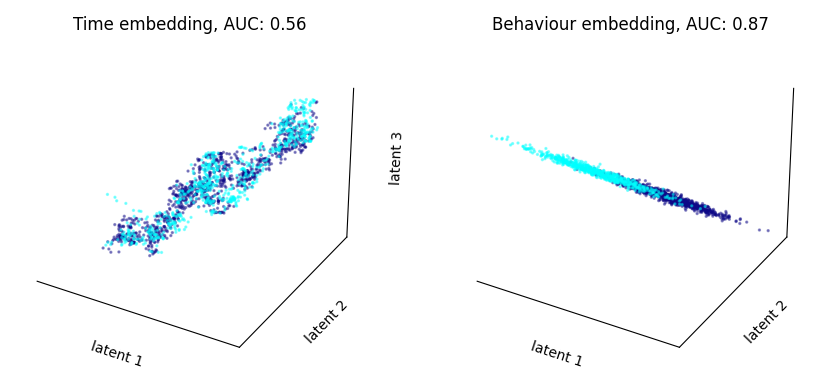

In [ ]:
# create a figure and make the plots
fig1 = plt.figure(figsize=(16,4))
gs = gridspec.GridSpec(1, 2, figure=fig1)

ax1 = fig1.add_subplot(gs[0,0], projection='3d')
ax2 = fig1.add_subplot(gs[0,1], projection='3d')
axes =[ax1,ax2]

for ax in axes:


    ax.set_xlabel("latent 1", labelpad=0.01)
    ax.set_ylabel("latent 2", labelpad=0.01)
    ax.set_zlabel("latent 3", labelpad=0.01)

    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.zaxis.set_tick_params(labelright=False)

    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])


# colour maps
colours = ['cool', 'plasma']

# plot the time embedding 
cebra.plot_embedding(embedding=time_embedding[left,:], embedding_labels=trial_labels[left],ax=ax1, markersize=2, title='Time embedding', cmap=colours[0])
cebra.plot_embedding(embedding=time_embedding[right,:], embedding_labels=trial_labels[right],ax=ax1, markersize=2, title='Time embedding, AUC: 0.56', cmap=colours[1])

# plot the behaviour embedding 
cebra.plot_embedding(embedding=behaviour_embedding[left,:], embedding_labels=trial_labels[left],ax=ax2, markersize=2, title='Behaviour embedding', cmap=colours[0],)
cebra.plot_embedding(embedding=behaviour_embedding[right,:], embedding_labels=trial_labels[right],ax=ax2,markersize=2, title='Behaviour embedding, AUC: 0.87',  cmap=colours[1])


# Adjust the subplot layout manually
#plt.subplots_adjust(left=0.095, right=0.1, top=0.95, bottom=0.05, wspace=0.001)

# Adjust the subplot layout manually
plt.subplots_adjust(left=0.00001, right=0.55, top=0.95, bottom=0.05, wspace=0.0001)

# Use tight_layout with padding to ensure labels are not cut off


# Adjust label positions using bbox
ax2.set_zlabel("latent 3", labelpad=1, fontsize=10, bbox=dict(facecolor='white', edgecolor='none', pad=0.5))


From this pair of embeddings we can see that there is a clustering of the left (light blue) and right (purple) trials when we use CEBRA behaviour. 
What if we tried using both the (left/right) choice and the number of licks in either direction.

In [ ]:
n_licks_ = n_licks.reshape(n_licks.shape[0],-1)
right_ = right.reshape(right.shape[0],-1).astype(np.float64)
left_ = left.reshape(left.shape[0], -1).astype(np.float64)

In [ ]:
print(n_licks_.shape)
print(right_.shape)
print(left_.shape)

(1717, 1)
(1717, 1)
(1717, 1)


In [ ]:
right

array([False, False, False, ..., False, False, False])

In [ ]:
# arrange the labels like in the hippocampus recordings experiment demo
lr_licks = np.concatenate((n_licks_,left_,right_), axis=1)
lr_licks.shape

(1717, 3)

In [ ]:
# build, train and compute with the time and behaviour models with this new labels
t_embed,b_embed =  utils.build_train_compute(formatted_nms,lr_licks)

pos:  0.9117 neg:  3.0025 total:  3.9142 temperature:  1.0000: 100%|██████████| 2000/2000 [00:50<00:00, 39.58it/s]
pos:  0.7137 neg:  5.2676 total:  5.9812 temperature:  1.0000: 100%|██████████| 2000/2000 [00:52<00:00, 38.29it/s]


In [ ]:
np.unique(lr_licks[:,0])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 21., 26.])

In [ ]:
# define a function to view the embeddings
def view(time_embedding, behaviour_embedding, labels, label_classes, size=5):
 
    # create a figure and make the plots
    fig = plt.figure(figsize=(14,8))
    gs = gridspec.GridSpec(1, 2, figure=fig)


    ax81 = fig.add_subplot(gs[0,0], projection='3d')
    ax82 = fig.add_subplot(gs[0,1], projection='3d')
 


    # colour maps
    colours = ['cool', 'plasma', 'spring']

    # plot the time embedding 
    cebra.plot_embedding(embedding=time_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0],0],ax=ax81, markersize=size, title='Time embedding', cmap=colours[0])
    cebra.plot_embedding(embedding=time_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1],0],ax=ax81, markersize=size, title='Time embedding', cmap=colours[1])


    # plot the behaviour embedding 
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[0],:], embedding_labels=labels[label_classes[0],0],ax=ax82, markersize=size, title='Behaviour embedding', cmap=colours[0],)
    cebra.plot_embedding(embedding=behaviour_embedding[label_classes[1],:], embedding_labels=labels[label_classes[1],0],ax=ax82,markersize=size, title='Behaviour embedding',  cmap=colours[1])

    gs.tight_layout(figure=fig)

In [ ]:
# define the classes
lr_classes = [left,right]
lr_classes[0].shape

(1717,)

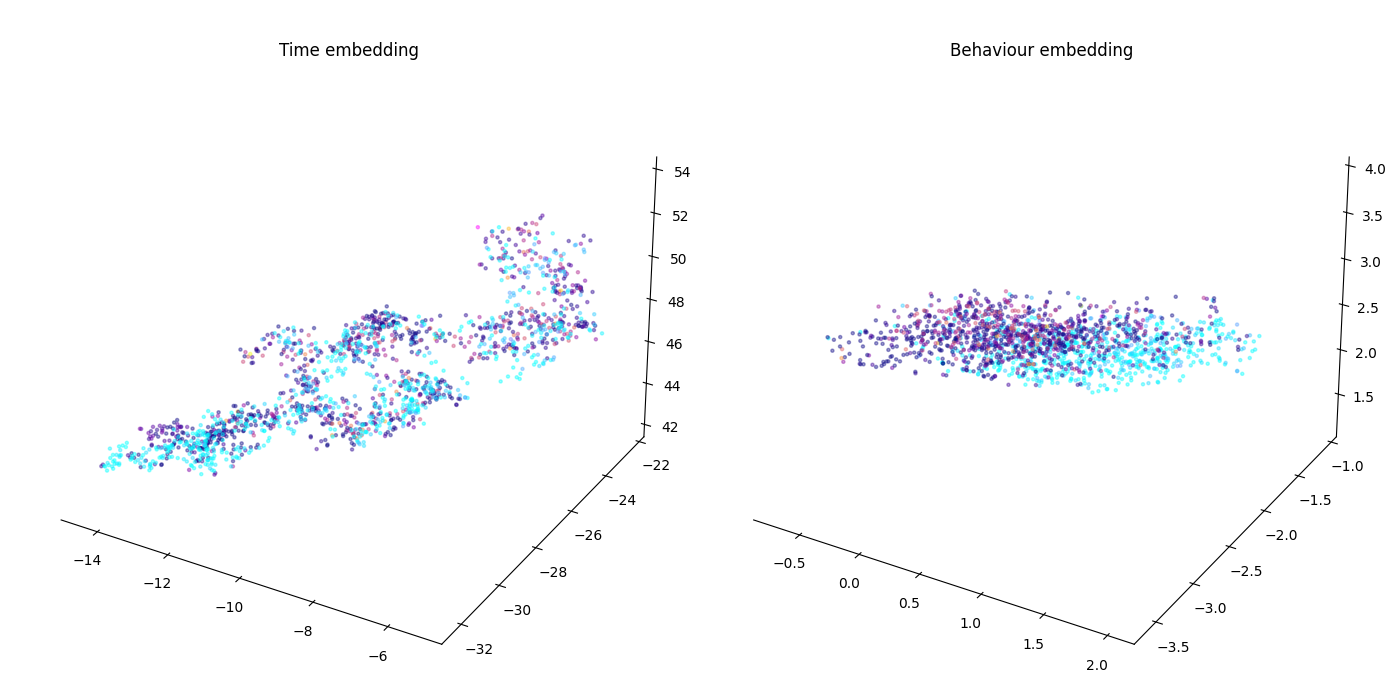

In [ ]:
view(t_embed, b_embed,lr_licks, lr_classes)

try this with the infoNCE setting -- maybe the behaviour embedding will make sense then

## Individual NMs

Now let's see how well the individual NMs capture the left/right choices.

In [ ]:
individual_nms = utils.individual_datasets(traces_=traces)

shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)
shape of formatted array: (218572, 1)


In [ ]:
b_embeds, t_embeds, t_labels, [positive, negative] = utils.nm_analysis_2(individual_nms, df_trials_ses, trace_times, choice_times, label='choice')